In [29]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter
import pandas as pd
from imblearn.over_sampling import SMOTE  


In [30]:
import models
import class_sampling
import train
import metric_utils
import inference
import loss_fns
import torchvision.ops 

In [31]:
NUM_CLASSES = 10
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
momentum = 0

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

NUM_CLASSES_REDUCED = 2
nums = (0, 1)
ratio = (100, 1)

CLASS_LABELS = {'airplane': 0,
                 'automobile': 1,
                 'bird': 2,
                 'cat': 3,
                 'deer': 4,
                 'dog': 5,
                 'frog': 6,
                 'horse': 7,
                 'ship': 8,
                 'truck': 9}


simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [32]:
# name, num_classes, classes used, ratio, learning rate, mean 10, variance 10, mean 20, variance 20, ... 50

# mean, variance every 10 epochs - average of 10 models 
# name, num_classes, classes used, ratio, learning rate, mean 10, variance 10, mean 20, variance 20, ... 50
# name: normal/ratio/oversampled/undersampled/weighted

col_names = ["name", 
            "num_classes", 
            "classes_used", 
            "ratio", 
            "learning_rate", 
            "mean_0", "variance_0",
            "mean_10", "variance_10",
            "mean_20", "variance_20",
            "mean_30", "variance_30",
            "mean_40", "variance_40",
            "mean_50", "variance_50"]

rows = []

In [33]:
train_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor() ]))  


test_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

train_CIFAR10.data = train_CIFAR10.data.reshape(50000, 3, 32, 32)
test_CIFAR10.data = test_CIFAR10.data.reshape(10000, 3, 32, 32)

    
reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.Ratio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums)

smote_train_CIFAR10 = class_sampling.Smote(ratio_train_CIFAR10)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
targets = ratio_train_CIFAR10.labels 

class_count = np.unique(targets, return_counts=True)[1]
print(class_count)

weight = 1. / class_count

samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
oversampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(max(class_count) * NUM_CLASSES_REDUCED), replacement=True)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
undersampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * NUM_CLASSES_REDUCED), replacement=False)

weight *= class_count[0]

[5000   50]


In [35]:
beta = 0.999 

exp = np.empty_like(targets)
for i, count in enumerate(class_count):
    exp[targets==i] = count
effective_weights = (1 - beta) / ( 1 - (beta ** torch.from_numpy(exp)))

In [36]:
print(effective_weights)

tensor([0.0010, 0.0010, 0.0010,  ..., 0.0205, 0.0205, 0.0205])


In [37]:
train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=oversampler)

train_loader_undersampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=undersampler)

train_loader_sampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=sampler)

train_loader_smote = DataLoader(smote_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True)

In [38]:
print(train_loader_smote.dataset.labels) # tupe instead of torch.Size() like the others 

tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.int32)


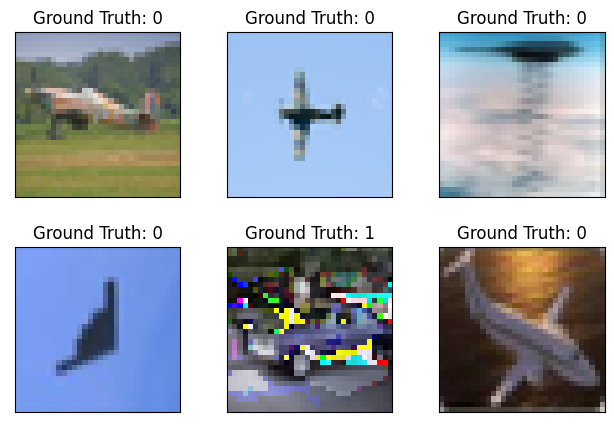

In [43]:
examples = enumerate(train_loader_smote) # enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i].reshape(32, 32, 3).int())
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [14]:
# SIGMOID 2 CLASS normal AUC saving  

momentum=0
learning_rates = [2e-5, 3e-5, 5e-5, 7e-5, 9e-5]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_reduced, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)
   


Test set: Avg. loss: 0.02460575580596924, AUC: 0.6469985


Test set: Avg. loss: 0.020814818382263185, AUC: 0.7692984999999999


Test set: Avg. loss: 0.0135240478515625, AUC: 0.8501124999999999



KeyboardInterrupt: 

In [ ]:
print(learning_rate_aucs.shape)
auc_mean = np.mean(learning_rate_aucs, axis=1)
print(auc_mean.shape)
auc_variance = np.var(learning_rate_aucs, axis=1)
print(auc_variance.shape)

for i in range(len(learning_rates)): 
    row = ["normal", 2, nums, (1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)

print(rows)

# pd.DataFrame(rows, columns = col_names) 

In [ ]:
# SIGMOID 2 CLASS ratio

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["ratio", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# SIGMOID 2 CLASS oversampled

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["oversampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# SIGMOID 2 CLASS undersampled

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["undersampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# SIGMOID 2 CLASS over+undersampled

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_sampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["both_sampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# SIGMOID 2 CLASS weighted 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['pos_weight'] = torch.tensor([weight[1]])

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["weighted", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [39]:
# 2 CLASS Focal Loss 
# no weights (yet)


momentum=0
learning_rates = [1e-4]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['reduction'] = 'mean'


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SigmoidFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["focal_loss", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.02157968044281006, AUC: 0.6867034999999999


Test set: Avg. loss: 0.06469440078735351, AUC: 0.616845


Test set: Avg. loss: 0.35850064086914063, AUC: 0.5


Test set: Avg. loss: 0.04972131156921387, AUC: 0.6774279999999999


Test set: Avg. loss: 0.7468457641601562, AUC: 0.5


Test set: Avg. loss: 0.04271893310546875, AUC: 0.7389560000000001


Test set: Avg. loss: 0.023658716201782226, AUC: 0.398378


Test set: Avg. loss: 0.013270419120788574, AUC: 0.7638875


Test set: Avg. loss: 0.03405495834350586, AUC: 0.7813830000000002


Test set: Avg. loss: 0.017646388053894044, AUC: 0.7801615


Test set: Avg. loss: 0.02234489631652832, AUC: 0.791094


Test set: Avg. loss: 0.036949007034301755, AUC: 0.7629790000000001


Test set: Avg. loss: 0.04466411209106445, AUC: 0.5848144999999999


Test set: Avg. loss: 0.08963019561767578, AUC: 0.5214759999999999


Test set: Avg. loss: 0.8179860534667969, AUC: 0.5


Test set: Avg. loss: 0.17512315368652343, AUC: 0.499


Test set: Avg. 

In [44]:
# 2 Class SMOTE 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_smote, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["smote", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.02460575580596924, AUC: 0.6469985


Test set: Avg. loss: 0.026045684814453126, AUC: 0.6504340000000001


Test set: Avg. loss: 0.01497733449935913, AUC: 0.7351255000000001


Test set: Avg. loss: 0.01858936882019043, AUC: 0.6978739999999999


Test set: Avg. loss: 0.020224379539489745, AUC: 0.688307


Test set: Avg. loss: 0.0205801362991333, AUC: 0.8344085000000001


Test set: Avg. loss: 0.02094214153289795, AUC: 0.459742


Test set: Avg. loss: 0.01317272424697876, AUC: 0.838303


Test set: Avg. loss: 0.010728169441223144, AUC: 0.7882945


Test set: Avg. loss: 0.020182360649108888, AUC: 0.835347


Test set: Avg. loss: 0.025778563499450683, AUC: 0.8216855


Test set: Avg. loss: 0.009684601306915282, AUC: 0.8063224999999999


Test set: Avg. loss: 0.048525693893432614, AUC: 0.59049


Test set: Avg. loss: 0.01905726909637451, AUC: 0.700017


Test set: Avg. loss: 0.05620224761962891, AUC: 0.6844739999999999


Test set: Avg. loss: 0.010672938346862794, AUC: 0.8569535


T


Test set: Avg. loss: 0.0027709816694259644, AUC: 0.758486


Test set: Avg. loss: 0.002616809606552124, AUC: 0.758127


Test set: Avg. loss: 0.07548549270629883, AUC: 0.49999600000000005


Test set: Avg. loss: 0.003938430190086365, AUC: 0.725591


Test set: Avg. loss: 0.003295870542526245, AUC: 0.747362


Test set: Avg. loss: 0.003393442630767822, AUC: 0.7736390000000001


Test set: Avg. loss: 0.002863102316856384, AUC: 0.7522115


Test set: Avg. loss: 0.0029881786108016967, AUC: 0.744436


Test set: Avg. loss: 0.027087728500366212, AUC: 0.44866949999999994


Test set: Avg. loss: 0.005449873447418213, AUC: 0.715775


Test set: Avg. loss: 0.003962276101112366, AUC: 0.7225360000000001


Test set: Avg. loss: 0.0035350985527038575, AUC: 0.7281434999999999


Test set: Avg. loss: 0.0036542681455612185, AUC: 0.7106265


Test set: Avg. loss: 0.00295078182220459, AUC: 0.736918


Test set: Avg. loss: 0.02875083065032959, AUC: 0.6469420000000001


Test set: Avg. loss: 0.004768420934677124, AUC: 0


Test set: Avg. loss: 0.009970030784606933, AUC: 0.48227600000000004


Test set: Avg. loss: 0.04632254409790039, AUC: 0.47904500000000005


Test set: Avg. loss: 0.012526666164398194, AUC: 0.582388


Test set: Avg. loss: 0.010988277435302734, AUC: 0.594391


Test set: Avg. loss: 0.009710521221160888, AUC: 0.6040715000000001


Test set: Avg. loss: 0.008653043270111084, AUC: 0.617047


Test set: Avg. loss: 0.007799698352813721, AUC: 0.630919


Test set: Avg. loss: 0.06196899604797363, AUC: 0.5754319999999999


Test set: Avg. loss: 0.0074221229553222655, AUC: 0.6066335


Test set: Avg. loss: 0.006804392099380493, AUC: 0.6222065


Test set: Avg. loss: 0.006396243810653687, AUC: 0.6348889999999999


Test set: Avg. loss: 0.0061254088878631595, AUC: 0.644071


Test set: Avg. loss: 0.005921830415725708, AUC: 0.6511915


Test set: Avg. loss: 0.03369696807861328, AUC: 0.4749055


Test set: Avg. loss: 0.00892920446395874, AUC: 0.5917525


Test set: Avg. loss: 0.008496898174285889, AUC: 0.6023225



In [104]:
# 2 class effective # of samples 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['pos_weight'] = effective_weights

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["effective_samples", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.021182982444763184, AUC: 0.672261


Test set: Avg. loss: 0.02040205478668213, AUC: 0.784783


Test set: Avg. loss: 0.008496701717376709, AUC: 0.7658635


Test set: Avg. loss: 0.010849761486053466, AUC: 0.7865255


Test set: Avg. loss: 0.014077957153320313, AUC: 0.8000940000000001


Test set: Avg. loss: 0.01160053539276123, AUC: 0.7966500000000001


Test set: Avg. loss: 0.01782694339752197, AUC: 0.5028665


Test set: Avg. loss: 0.023290175437927246, AUC: 0.7743450000000001


Test set: Avg. loss: 0.020170438766479493, AUC: 0.7914720000000001


Test set: Avg. loss: 0.0160395770072937, AUC: 0.780689


Test set: Avg. loss: 0.0165785551071167, AUC: 0.7878360000000001


Test set: Avg. loss: 0.015160138607025147, AUC: 0.78366


Test set: Avg. loss: 0.05102617263793945, AUC: 0.5758955


Test set: Avg. loss: 0.02155221652984619, AUC: 0.765247


Test set: Avg. loss: 0.008215628385543823, AUC: 0.7573829999999999


Test set: Avg. loss: 0.010915471076965331, AUC: 0.7642705000

KeyboardInterrupt: 

In [9]:
NUM_CLASSES_REDUCED = 3
nums = (0, 3, 1)
ratio = (20, 2, 1)


reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.Ratio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums)
targets = ratio_train_CIFAR10.labels 
class_count = np.unique(targets, return_counts=True)[1]

smote_train_CIFAR10 = class_sampling.Smote(ratio_train_CIFAR10)


weight = 1. / class_count
samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
oversampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(max(class_count) * NUM_CLASSES_REDUCED), replacement=True)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
undersampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * NUM_CLASSES_REDUCED), replacement=False)

weight *= max(class_count)


train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=oversampler)

train_loader_undersampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=undersampler)

train_loader_sampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=sampler)

train_loader_smote = DataLoader(smote_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True)

In [12]:
# Softmax 3 class normal

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_reduced, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["normal", 3, nums, (1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.01616737683614095, AUC: 0.580682

tensor([[ 6.9793e+01,  7.2243e+00, -1.1648e+02],
        [ 3.7404e+00,  5.3265e+01, -2.2669e+01],
        [ 3.5517e+01, -2.0166e+01, -7.3936e+01],
        [ 1.3600e+01,  4.4182e+01, -8.0599e+01],
        [ 5.7199e+01,  4.5885e+01, -3.2801e+01],
        [ 7.3769e+01,  5.2824e+01, -9.2603e+01],
        [ 2.4047e+01,  2.1550e+01, -4.9672e+01],
        [ 2.5542e+01,  1.8979e+01, -3.5012e+01],
        [ 5.9217e+01,  4.4618e+01, -2.0481e+01],
        [-4.1457e+01,  9.9023e+01, -7.0097e+01],
        [-3.4331e+00,  8.3277e+01, -3.4352e+01],
        [ 5.1157e+01,  4.8483e+01, -4.6867e+01],
        [ 3.4588e+01,  3.9027e+01, -5.7833e+01],
        [ 1.6052e+01,  7.7187e+01, -8.9317e+01],
        [ 8.9617e+00,  6.2920e+01, -3.1778e+01],
        [ 7.5736e+01,  2.8788e+00, -4.8434e+01],
        [ 5.9357e+01,  5.7808e+01, -8.4619e+01],
        [-4.5496e+01,  3.3742e+01, -1.2218e+02],
        [ 4.6836e+01,  2.9279e+01, -8.4916e+01],
        [ 9

tensor([[   1.4248,  151.7146,  -31.3662],
        [  34.0740,   40.8156,  -45.8902],
        [  71.2530,   41.4659,  -94.4284],
        [  53.9268,   -1.6918,  -45.9590],
        [ -56.3148,   59.0073,  -27.1035],
        [ 111.8482,   -4.8195,  -94.3949],
        [ 154.2720,   28.2734,  -56.8762],
        [  30.9362,   88.1379, -121.7021],
        [ -37.6852,   93.9982,  -53.0467],
        [  -2.8856,   75.6214, -120.1988],
        [ -44.2328,   79.1941,  -29.0473],
        [-113.7735,  145.2189,  -70.3945],
        [  49.6424,   86.7524,  -77.3830],
        [  31.4845,   17.9643,  -82.9617],
        [ -29.6926,  101.7114,  -59.3845],
        [ -17.0365,   79.6865,  -94.3772],
        [  67.1492,   91.6184, -107.7478],
        [  84.8298,   13.2613,  -80.8471],
        [ -19.9114,   44.6261, -104.8964],
        [ -13.3612,  141.5048,  -44.6673],
        [ -50.5163,  142.0188,  -69.1747],
        [  84.2443,   32.8220,  -55.9002],
        [  97.7693,  -18.6637,  -56.8337],
        [ -

tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1])
tensor([[ 4.2694e+01,  4.6440e+01, -8.4177e+01],
        [-1.2712e+01,  9.6897e+01, -8.5050e+01],
        [ 1.0690e+02,  1.9496e+01, -9.2835e+01],
        [ 6.4262e+01,  8.3262e+00, -5.7009e+01],
        [-5.4608e+01,  1.0152e+02, -8.3236e+01],
        [-3.6139e+01,  1.3610e+02, -2.0939e-01],
        [ 7.8680e+01,  3.0241e+01, -4.3018e+01],
        [ 4.8304e+01, -1.2732e+00, -4.5207e+01],
        [-5.1740e+01,  4.4084e+01, -2.7858e+01],
        [-7.4165e+01,  1.2047e+02, -3.3418e+01],
        [ 1.7443e+02, -6.0421e+01, -5.9264e+01],
        [-6.1850e+01,  1.1511e+02, -1.0409e+02],
        [-8.6781e+01,  1.0431e+02, -1.0232e+02],
        [ 1.1185e+02,  8.5327e+00, -8.3141e+01],
        [ 5.3495e+01, -2.2265e+01, -6.2774e+01],
        [ 1.2220e+02, -6.8793e+01, -1.2259e+02],

tensor([[  87.3361,   12.8988,  -46.8307],
        [  16.0811,   79.9086,  -54.3280],
        [ 226.5628, -122.4337,  -87.9310],
        [ 147.9549,  -45.9791,  -45.0867],
        [ -67.7177,   35.2486, -120.1186],
        [  12.7137,   42.5581,   -8.0266],
        [ 135.9230,   33.8580,  -42.4314],
        [ -32.9709,   41.3133,  -62.7985],
        [  40.4296,    5.5214, -119.0663],
        [ 177.4341,  -48.9483, -120.5948],
        [  19.5438,  119.6792,  -78.5486],
        [  83.7152,  -63.4320,  -32.5842],
        [ -39.9082,   89.3602,  -96.3648],
        [ 195.3534,  -54.6748,  -93.8925],
        [ 131.3991,  -58.1297,  -70.6824],
        [ 147.5331,  -58.7925,  -90.5310],
        [ 204.8473,  -22.5315, -114.3230],
        [  -1.7327,  112.6726,  -12.3950],
        [ 112.5851,  -64.2510,  -68.4568],
        [  21.5370,  101.1145,  -77.9057],
        [  24.2755,  148.8217,  -27.1583],
        [ 204.3673,  -57.5910,  -44.7102],
        [  88.7547,   -8.7618,  -82.6193],
        [ -

tensor([[  69.4846,    0.8726,  -76.4713],
        [  41.5583,   71.9539, -135.8457],
        [ -60.6408,   82.7620,  -53.9683],
        [   0.6590,   39.3754,  -79.8594],
        [  54.1492,  103.7774, -123.7015],
        [ -89.0272,   95.3935,  -56.7234],
        [ -57.7910,  129.8081,  -96.6868],
        [  46.1179,  114.6622,  -63.0623],
        [ 115.2638,  -33.9128,  -34.5608],
        [ -47.3852,  150.6851,  -76.1027],
        [  56.8492,  -15.1652,  -73.6693],
        [ -65.4251,  166.2375, -100.2308],
        [  95.7997,  -24.6732,  -78.9157],
        [   5.5896,   70.5129,  -39.1901],
        [ -92.0327,  165.3879,  -94.1898],
        [ 194.9890,  -75.9603, -127.2830],
        [ -40.1746,   89.1865,  -78.2802],
        [ -12.0172,  132.5616,  -71.3836],
        [  39.9505,   84.5152,  -38.7756],
        [ -10.1107,  121.6037, -120.9404],
        [  22.4135,  115.4811,  -68.0289],
        [  22.2951,   -3.7049,  -60.2429],
        [   4.4670,   89.4917,  -52.7402],
        [ 1

tensor([[  72.9635,  -13.0379,  -40.2845],
        [ -85.5796,  144.2339,  -74.9902],
        [ 184.5890,  -62.0574,  -85.3471],
        [ 129.7528,  -62.7425,  -38.1907],
        [  -6.8909,  100.7182,  -27.6065],
        [   9.8067,   47.3178,  -46.7651],
        [  68.6656,   23.2908,  -70.2128],
        [ 177.0230, -116.3884,  -43.4554],
        [  96.1692,  -38.8840,  -63.6445],
        [ 162.9050,  -87.3509,  -61.8373],
        [ 124.9622,  -27.8258,  -86.8815],
        [ 299.6512, -184.6520, -122.6066],
        [ 128.8459,  -98.6303, -141.8645],
        [ 213.7080, -106.1832, -161.0468],
        [ 141.3059,  -97.9625, -101.2405],
        [ 263.8069, -147.5307, -123.7616],
        [ 190.0594, -132.9925,  -51.1284],
        [ 271.0023, -127.6935,  -70.7492],
        [ 169.0193, -120.1186,  -92.3637],
        [  48.0033,    8.6860,  -40.5813],
        [ 169.4922,  -42.6275,  -70.9140],
        [  -4.3726,   64.9466,  -80.3009],
        [ 149.5035, -133.6775,  -88.6950],
        [  

tensor([1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1])
tensor([[ -98.2129,  147.8865,  -88.6619],
        [ 128.4113,   64.3812, -162.7984],
        [ -37.5897,  118.6096,  -75.2798],
        [ -89.3089,  116.2573,  -84.3940],
        [  96.5373,   12.1169,  -58.7873],
        [ -92.4472,  203.3508,  -46.4248],
        [  64.9588,   27.4613,  -95.3629],
        [ 167.4964, -123.2788,  -90.1893],
        [-102.2176,  116.7820, -133.8755],
        [ -45.5577,   53.5326,  -67.2196],
        [  -4.2064,  100.7155,  -81.8514],
        [  39.4183,   52.6111, -136.6073],
        [-144.9349,  192.5878, -106.7774],
        [-201.8636,  246.5082,  -91.6167],
        [-158.8822,  252.2784, -149.8184],
        [ -54.1699,  107.7717,  -60.2993],
        [  17.2601,   94.6078, -127.3489],
        [ -23.9904,   74.2091,  -56.8126],
        [

tensor([[-4.7948e+01,  9.4647e+01, -9.8626e+01],
        [ 7.2613e+01,  6.6653e+01, -1.3468e+02],
        [ 1.7576e+02, -5.5476e+01, -8.9691e+01],
        [ 2.2248e+02, -1.1777e+02, -4.2568e+01],
        [ 9.9839e+01, -9.9652e+01, -9.8759e+01],
        [ 1.7373e+02, -9.7287e+01, -1.2814e+02],
        [ 1.9018e+02, -1.2669e+02, -1.0984e+02],
        [ 7.3018e+01, -1.8918e+01, -9.1734e+01],
        [ 1.7514e+02, -7.4017e+01, -1.1718e+02],
        [-6.7216e+01,  5.5574e+01, -8.3698e+01],
        [ 1.1318e+02, -5.7510e+01, -7.6602e+01],
        [ 6.6117e+01,  1.1844e+02, -8.8512e+01],
        [-2.0836e+02,  2.4808e+02, -8.0992e+01],
        [-3.4224e+01,  1.6065e+02, -4.4245e+01],
        [ 9.8461e+01, -3.4576e+00, -8.0621e+01],
        [ 7.8615e+01,  1.4636e+00, -1.3781e+02],
        [ 8.7910e+01, -2.2483e+01, -3.2766e+01],
        [ 1.6054e+02, -5.6741e+01, -8.5798e+01],
        [ 9.1612e+01,  9.8137e+00, -7.2160e+01],
        [ 6.5362e+00,  1.2179e+01, -5.1965e+01],
        [-9.3870e+01

tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0])
tensor([[ 163.1197,  -60.1649, -115.3418],
        [ 100.4203,   -6.4716,  -87.4263],
        [ 112.7402,    3.7953, -100.3478],
        [ -43.9361,  126.1645,  -90.4375],
        [  45.9019,  -13.4540,  -64.1398],
        [   3.5642,   41.8338,  -56.2721],
        [  -6.5861,  192.1723,  -85.6597],
        [ 121.2372,  -79.0842, -110.6612],
        [  36.3348,   52.5430,  -88.3818],
        [  79.6479,  -32.5510,  -74.8288],
        [ 107.6412,  -53.4582, -116.4191],
        [ 168.5757,    9.6021, -148.1758],
        [ 289.5561, -118.3850,  -86.6334],
        [  95.1217,  -32.7342,  -74.8894],
        [ -21.8626,    4.4324,  -78.6843],
        [  45.4205,  -11.8125, -114.7496],
        [ 336.4787, -202.4667, -109.9707],
        [  -5.8131,   64.4483,  -81.1856],
        [

tensor([[-123.2807,  192.5995,  -46.2844],
        [   8.6907,   32.8493,   -9.1883],
        [ 187.3025,  -32.5190,  -91.8598],
        [ -58.9135,  134.5760,  -58.6658],
        [  52.1174,   90.6319, -111.8895],
        [  68.5997,   12.2881,  -84.7239],
        [ -71.2325,  174.7677, -136.1394],
        [ -38.8599,  154.2439,   -4.7124],
        [-106.2648,  131.7222, -139.8927],
        [ -68.1651,  141.9666,  -59.6137],
        [-101.6461,  211.0518,  -80.8091],
        [ -40.0690,  163.3388,  -80.3533],
        [  -6.8095,  112.1288, -113.5238],
        [  92.5060,  -18.8850,  -37.5197],
        [  25.3044,   81.3225, -125.1138],
        [ -34.9603,  101.3399,  -63.2675],
        [  66.9074,    4.3881, -117.6488],
        [-104.3235,  226.8120,  -84.5560],
        [ -97.6139,  201.2309,  -85.7871],
        [  -5.0888,  156.4666, -124.5874],
        [ -72.7318,  130.2408,  -54.0546],
        [ -73.5585,  172.7101,  -53.2670],
        [ -35.8419,  185.4603,  -86.8259],
        [  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# Softmax 3 class ratio

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["ratio", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [16]:
# Softmax 3 class oversampled

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["oversampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.01764530849456787, AUC: 0.5389999999999999


Test set: Avg. loss: 0.035015865325927736, AUC: 0.6815


Test set: Avg. loss: 0.05701504135131836, AUC: 0.611


Test set: Avg. loss: 0.0557035026550293, AUC: 0.6060000000000001


Test set: Avg. loss: 0.06728232192993164, AUC: 0.5825



KeyboardInterrupt: 

In [ ]:
# Softmax 3 class undersampled

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["undersampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# Softmax 3 class both sampled

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_sampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["both_sampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# Softmax 3 class weighted

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

loss_fn_args={}
loss_fn_args['weight'] = torch.from_numpy(class_weights).float()

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["weighted", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [10]:
# Softmax 3 class focal loss 

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

loss_fn_args={}
loss_fn_args['reduction'] = 'mean'

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SoftmaxFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["focal_loss", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.18454894002278646, AUC: 0.4975


Test set: Avg. loss: 0.08534454600016277, AUC: 0.5097492499999999


Test set: Avg. loss: 0.03880809783935547, AUC: 0.59175


Test set: Avg. loss: 0.2429783020019531, AUC: 0.5005


Test set: Avg. loss: 0.11458427174886068, AUC: 0.5322465000000001


Test set: Avg. loss: 0.02197437032063802, AUC: 0.7309375


Test set: Avg. loss: 0.1425031280517578, AUC: 0.49474999999999997


Test set: Avg. loss: 0.1414619344075521, AUC: 0.501


Test set: Avg. loss: 0.03537759145100911, AUC: 0.7539175


Test set: Avg. loss: 0.286093994140625, AUC: 0.49974999999999997


Test set: Avg. loss: 0.07872645314534506, AUC: 0.5222245000000001


Test set: Avg. loss: 0.023918342590332032, AUC: 0.6959565


Test set: Avg. loss: 0.11955121612548827, AUC: 0.496501


Test set: Avg. loss: 0.045689868927001956, AUC: 0.58031475


Test set: Avg. loss: 0.04220397440592448, AUC: 0.64794875


Test set: Avg. loss: 0.04487620417277018, AUC: 0.604751


Test set: Avg. loss: 0.


Test set: Avg. loss: 0.017591241836547852, AUC: 0.5994370000000001


Test set: Avg. loss: 0.017861193339029947, AUC: 0.6007440000000001


Test set: Avg. loss: 0.015261752128601074, AUC: 0.6257287500000001


Test set: Avg. loss: 0.013568886756896973, AUC: 0.64376225


Test set: Avg. loss: 0.016622880935668945, AUC: 0.6239375


Test set: Avg. loss: 0.1057866923014323, AUC: 0.5


Test set: Avg. loss: 0.018792335510253905, AUC: 0.6431749999999999


Test set: Avg. loss: 0.018748268127441407, AUC: 0.6341712500000001


Test set: Avg. loss: 0.01514268398284912, AUC: 0.6464885


Test set: Avg. loss: 0.01538328774770101, AUC: 0.6503739999999999


Test set: Avg. loss: 0.01590768082936605, AUC: 0.636499


Test set: Avg. loss: 0.09206764729817708, AUC: 0.486987


Test set: Avg. loss: 0.018593992233276367, AUC: 0.642598


Test set: Avg. loss: 0.01674135653177897, AUC: 0.6337472500000001


Test set: Avg. loss: 0.014079053560892741, AUC: 0.65653525


Test set: Avg. loss: 0.01488720448811849, AUC: 0.6


Test set: Avg. loss: 0.04290089670817057, AUC: 0.52643575


Test set: Avg. loss: 0.03936661911010742, AUC: 0.52577825


Test set: Avg. loss: 0.036868096669514974, AUC: 0.52678875


Test set: Avg. loss: 0.0344744758605957, AUC: 0.532583


Test set: Avg. loss: 0.0325801690419515, AUC: 0.538813


Test set: Avg. loss: 0.13629820760091146, AUC: 0.49575


Test set: Avg. loss: 0.05195193735758463, AUC: 0.576489


Test set: Avg. loss: 0.033686952590942384, AUC: 0.58485025


Test set: Avg. loss: 0.030500649134318034, AUC: 0.5837964999999999


Test set: Avg. loss: 0.029526135762532553, AUC: 0.584436


Test set: Avg. loss: 0.028707168579101563, AUC: 0.5872390000000001


Test set: Avg. loss: 0.05461425908406575, AUC: 0.5207605000000001


Test set: Avg. loss: 0.03587385940551758, AUC: 0.6037375


Test set: Avg. loss: 0.03680088678995768, AUC: 0.601498


Test set: Avg. loss: 0.03595838673909505, AUC: 0.6038365


Test set: Avg. loss: 0.03503180185953776, AUC: 0.604364


Test set: Avg. loss: 0.034229

In [11]:
# 3 class SMOTE 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(3, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_smote, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)
    
learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["smote", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.14818951416015624, AUC: 0.50025


Test set: Avg. loss: 0.020921210606892903, AUC: 0.7300610000000001


Test set: Avg. loss: 0.19352812194824218, AUC: 0.6855610000000001


Test set: Avg. loss: 0.028447001139322917, AUC: 0.758624


Test set: Avg. loss: 0.14001809692382813, AUC: 0.74474675


Test set: Avg. loss: 0.08408636728922526, AUC: 0.5567387500000001


Test set: Avg. loss: 0.04121090825398763, AUC: 0.5309740000000001


Test set: Avg. loss: 0.05444798151652018, AUC: 0.6307499999999999


Test set: Avg. loss: 0.026480026880900065, AUC: 0.7417317499999999


Test set: Avg. loss: 0.015619597752888997, AUC: 0.6951055000000002


Test set: Avg. loss: 0.05263480122884114, AUC: 0.729264


Test set: Avg. loss: 0.15237850443522136, AUC: 0.520515


Test set: Avg. loss: 0.03359843190511068, AUC: 0.561713


Test set: Avg. loss: 0.07664698537190755, AUC: 0.66300575


Test set: Avg. loss: 0.0292024294535319, AUC: 0.7608732500000001


Test set: Avg. loss: 0.09107918548583985, A


Test set: Avg. loss: 0.006462000370025635, AUC: 0.72927


Test set: Avg. loss: 0.018464927673339845, AUC: 0.438944


Test set: Avg. loss: 0.0103206205368042, AUC: 0.69050525


Test set: Avg. loss: 0.0077791109085083, AUC: 0.6734089999999999


Test set: Avg. loss: 0.005709005037943522, AUC: 0.6914462499999999


Test set: Avg. loss: 0.007815112749735514, AUC: 0.7280955000000001


Test set: Avg. loss: 0.007605897426605225, AUC: 0.6049945


Test set: Avg. loss: 0.05217159907023112, AUC: 0.5019895


Test set: Avg. loss: 0.011967073440551758, AUC: 0.666864


Test set: Avg. loss: 0.011580034573872884, AUC: 0.6573040000000001


Test set: Avg. loss: 0.007489019711812337, AUC: 0.699521


Test set: Avg. loss: 0.011743113517761231, AUC: 0.70177575


Test set: Avg. loss: 0.008342960993448893, AUC: 0.6811865


Test set: Avg. loss: 0.027873291015625, AUC: 0.4150849999999999


Test set: Avg. loss: 0.01417051887512207, AUC: 0.6930667500000001


Test set: Avg. loss: 0.012346324602762858, AUC: 0.7105039


Test set: Avg. loss: 0.021455603917439777, AUC: 0.5794100000000001


Test set: Avg. loss: 0.020580517450968425, AUC: 0.588598


Test set: Avg. loss: 0.05863334401448568, AUC: 0.48871600000000004


Test set: Avg. loss: 0.018124800364176432, AUC: 0.58254775


Test set: Avg. loss: 0.017425732930501304, AUC: 0.59169675


Test set: Avg. loss: 0.017120988210042317, AUC: 0.5939555


Test set: Avg. loss: 0.016958574930826822, AUC: 0.60343425


Test set: Avg. loss: 0.016583613713582357, AUC: 0.6171295000000001


Test set: Avg. loss: 0.05163104756673177, AUC: 0.541042


Test set: Avg. loss: 0.029498812993367513, AUC: 0.5365264999999999


Test set: Avg. loss: 0.026108721415201822, AUC: 0.5539989999999999


Test set: Avg. loss: 0.023814554214477538, AUC: 0.5691465


Test set: Avg. loss: 0.02268533706665039, AUC: 0.58836175


Test set: Avg. loss: 0.021658046086629232, AUC: 0.6017925


Test set: Avg. loss: 0.06003434499104818, AUC: 0.530015


Test set: Avg. loss: 0.022820605595906575, AUC: 0.605416

In [40]:
df1 = pd.read_csv('results/auc_analysis_other_methods.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

In [41]:
df2.head(10)

,name,num_classes,classes_used,ratio,learning_rate,mean_0,variance_0,mean_10,variance_10,mean_20,variance_20,mean_30,variance_30,mean_40,variance_40,mean_50,variance_50
0,focal_loss,2,"(0, 1)","(100, 1)",0.0001,0.548379,0.009424,0.616762,0.013345,0.607981,0.016604,0.696444,0.014424,0.694727,0.012912,0.713047,0.016529


In [42]:
df.to_csv('results/auc_analysis_other_methods.csv', index=False)
# df.to_csv('results/auc_analysis.csv', index=False)